In [2]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the data
df = pd.read_csv('model_data.csv', index_col = 0)

In [ ]:
# Data for iterative imputing
df_iter_impute = df.copy()

In [ ]:
# Data prepared for catboost test
df_cat = df.copy()

#### Dealing with missing values

- Create 'missing' variables for columns with NaNs

In [5]:
# Create an indicator column for LowDoc_Encoded NAs
df['LowDoc_Encoded_missing'] = df['LowDoc_Encoded'].isna().astype(int)

# Create an indicator column for LowDoc_Encoded NAs
df['RevLineCr_Encoded_missing'] = df['RevLineCr_Encoded'].isna().astype(int)

# Create an indicator column for LowDoc_Encoded NAs
df['NewExist_Encode_missing'] = df['NewExist_Encode'].isna().astype(int)

- Iteratively fill missing data points for columns with NaNs

In [ ]:
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier

# Create a copy of the DataFrame
df_target = df[['UrbanRural_Encoded', 'GrAppv', 'FranchiseCode_Encoded',
                       'LowDoc_Encoded', 'RevLineCr_Encoded', 'NewExist_Encode']]

# Initialize the IterativeImputer
imputer = IterativeImputer(estimator=RandomForestClassifier(), random_state=42)

# Fit and transform the numeric columns
df_imputed = imputer.fit_transform(df_target)

df_imputed =pd.DataFrame(df_imputed, columns=df_target.columns)


,UrbanRural_Encoded,GrAppv,FranchiseCode_Encoded,LowDoc_Encoded,RevLineCr_Encoded,NewExist_Encode
0,0.0,60000.0,0.0,1.0,0.0,0.0
1,0.0,40000.0,0.0,1.0,0.0,0.0
2,0.0,287000.0,0.0,0.0,0.0,1.0
3,0.0,35000.0,0.0,1.0,0.0,1.0
4,0.0,229000.0,0.0,0.0,0.0,1.0


In [ ]:
# Create a list of columns used for the inputing
itered_columns = df_imputed.columns

# Fill NaNs with result from iterative inputs
df_iter_impute[itered_columns] = df_imputed[itered_columns]

# Verify no NaNs dataset
df_iter_impute.isna().sum()

#### One-Hot Encode categories

In [29]:
# One Hot-Encode the categorical variables
df_iter_impute = pd.get_dummies(df_iter_impute, columns=['Region', 'BankRegion']).fillna(0).astype('int64')

#### Check for Multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df_iter_impute.drop(columns=['MIS_Status_Encoded']))

# Calculate the VIF for each feature
vif = pd.DataFrame()
vif["features"] = df_iter_impute.drop(columns=['MIS_Status_Encoded']).columns
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

vif['VIF Factor'] = round(vif['VIF Factor'], 2)

# Print the results
vif

In [ ]:
# View the correlation between created and retained jobs.
df_iter_impute[['CreateJob', 'RetainedJob']].corr()

#  Similar VIF values observed

,CreateJob,RetainedJob
CreateJob,1.000000,0.993955
RetainedJob,0.993955,1.000000


In [ ]:
# Drop one of the co-linear features
df_iter_impute.drop(columns=['TermDays', 'BankRegion_Southern', 'BankRegion_Western', 'BankRegion_Northern', 'BankRegion_Eastern', 'RetainedJob'], inplace=True)

In [ ]:
# Re-run VIF for multicolineairty test

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df_iter_impute.drop(columns=['MIS_Status_Encoded']))

# Calculate the VIF for each feature
vif = pd.DataFrame()
vif["features"] = df_iter_impute.drop(columns=['MIS_Status_Encoded']).columns
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

vif['VIF Factor'] = round(vif['VIF Factor'], 2)

# Confirm no mutlticollineairty in dataset (VIF > 5)
vif

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


## Outlier Detection (IQR)

In [13]:
def remove_outliers_iqr(df, column):
    """Removes outliers from a DataFrame column using the IQR method.

    Args:
        df: The Pandas DataFrame.
        column: The name of the column to remove outliers from.

    Returns:
        A new DataFrame with the outliers removed.
    """

    # Calculate quantiles and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter data within bounds
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_filtered

# Remove outliers from the DataFrame:
df_no_outliers_cj = remove_outliers_iqr(df_no_multicollinearity, 'CreateJob')
df_no_outliers_tm = remove_outliers_iqr(df_no_outliers_cj, 'Term')
df_no_outliers_ne = remove_outliers_iqr(df_no_outliers_tm, 'NoEmp')
df_no_outliers_naic = remove_outliers_iqr(df_no_outliers_ne, 'NAICS')
df_no_outliers_naic_cd = remove_outliers_iqr(df_no_outliers_naic, 'NAICS_class_code')
df_no_outliers = remove_outliers_iqr(df_no_outliers_naic_cd, 'GrAppv')

# Print the shape of the DataFrame before and after outlier removal
print("Shape before outlier removal:", df_no_multicollinearity.shape)
print("Shape after outlier removal:", df_no_outliers.shape)


Shape before outlier removal: (613723, 17)
Shape after outlier removal: (371615, 17)


In [14]:
df_no_multicollinearity.shape[0] - df_no_outliers.shape[0]

242108

## Validate Linearity Assumption

#### Perform Box-Tidwell Test to examine the relationship between continous variables and the logit (target).

In [15]:
df_no_outliers.head()

,MIS_Status_Encoded,NewExist_Encode,GrAppv,CreateJob,UrbanRural_Encoded,RevLineCr_Encoded,LowDoc_Encoded,NAICS,NAICS_class_code,FranchiseCode_Encoded,Term,NoEmp,RealEstate_Backed,Region_Eastern,Region_Northern,Region_Southern,Region_Western
0,1,0,60000,0,0,0,1,451120,45,0,84,4,0,1,0,0,0
1,1,0,40000,0,0,0,1,722410,72,0,60,2,0,1,0,0,0
3,1,1,35000,0,0,0,1,0,81,0,60,2,0,1,0,0,0
7,1,0,45000,0,0,0,1,811118,81,0,84,1,0,1,0,0,0
9,1,0,70000,0,0,0,1,0,81,0,84,3,0,0,1,0,0


#### Without Outliers

Optimization terminated successfully.
         Current function value: 0.411528
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:     MIS_Status_Encoded   No. Observations:               371615
Model:                          Logit   Df Residuals:                   371608
Method:                           MLE   Df Model:                            6
Date:                Fri, 07 Feb 2025   Pseudo R-squ.:                  0.2224
Time:                        23:17:45   Log-Likelihood:            -1.5293e+05
converged:                       True   LL-Null:                   -1.9667e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.7740      0.006    311.640      0.000       1.763       1.785
GrAppv     

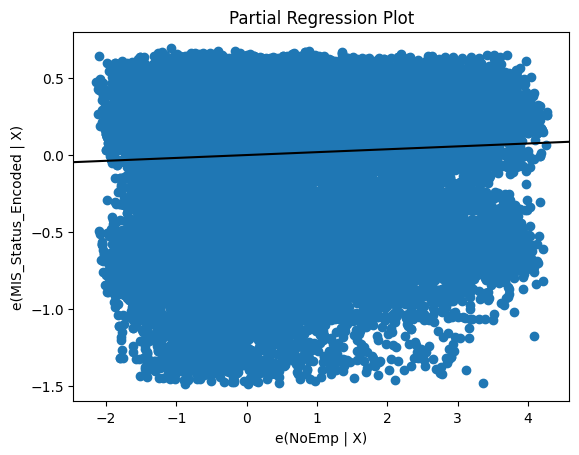

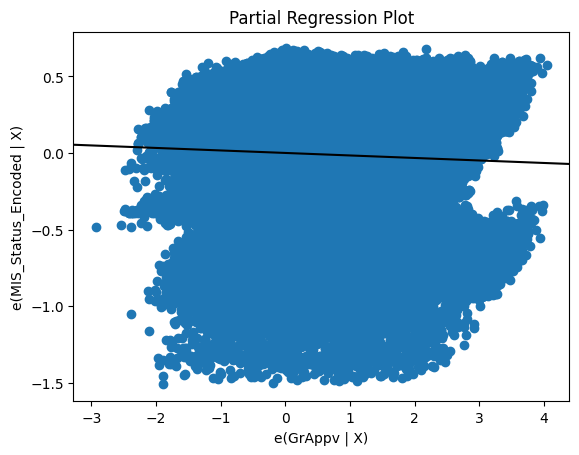

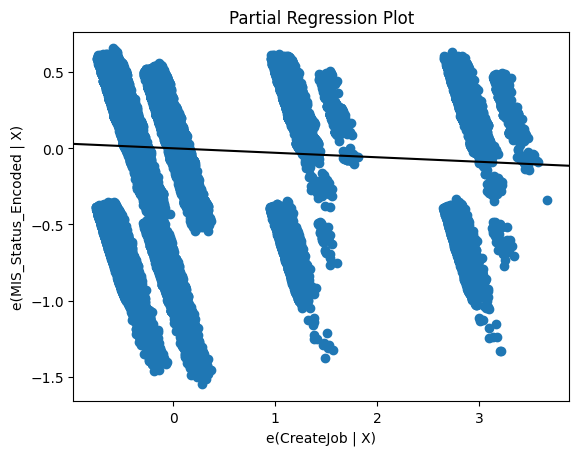

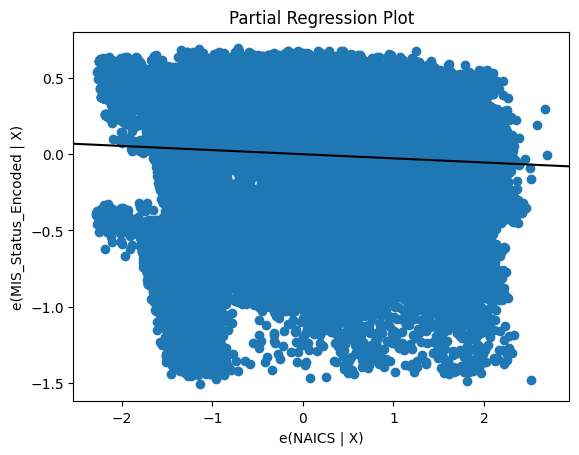

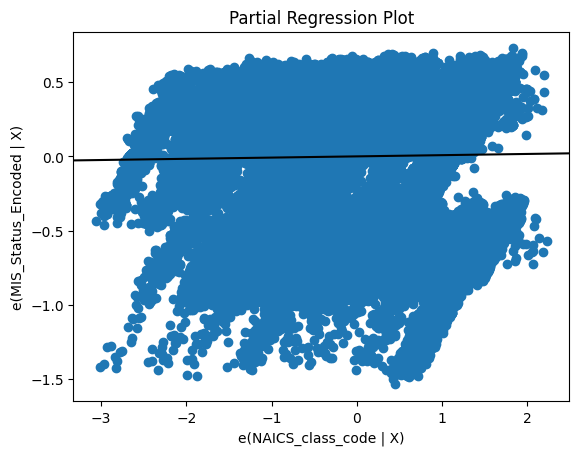

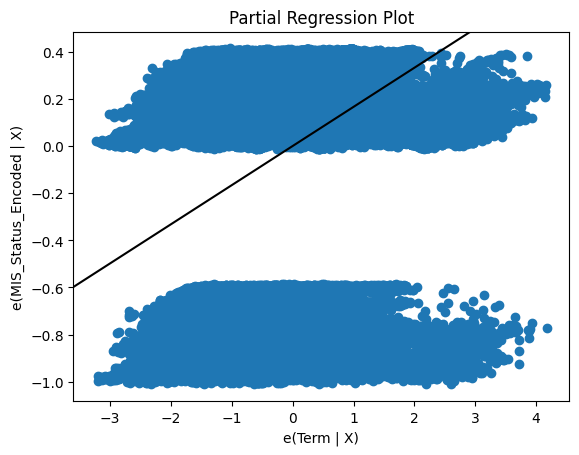

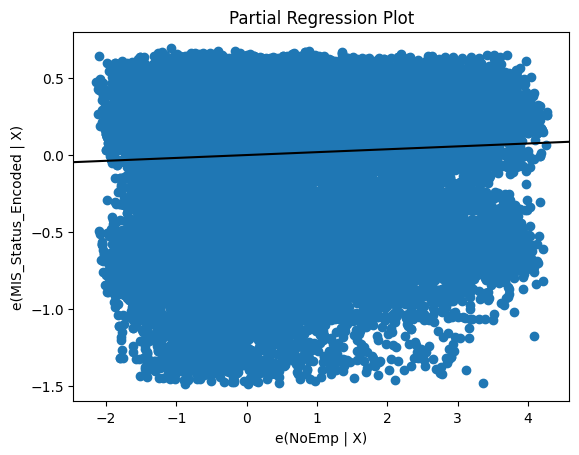

In [16]:
import statsmodels.api as sm
import statsmodels.graphics.api as smg
from sklearn.preprocessing import StandardScaler

# Create DataFrame
df_test_no_outlier = df_no_outliers[['MIS_Status_Encoded', 'GrAppv', 'CreateJob', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp']]

# Select predictor features
continous_features_no_outliers = df_test_no_outlier[['GrAppv', 'CreateJob', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp']]

# Standardize the features
scaler = StandardScaler()
continous_features_no_outliers = scaler.fit_transform(continous_features_no_outliers)

# Convert the features to a DataFrame
continous_features_no_outliers = pd.DataFrame(continous_features_no_outliers, columns=['GrAppv', 'CreateJob', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp'])

# Target feature
target_feature = df_test_no_outlier['MIS_Status_Encoded']

# Concatenate the features and target
df_test_final_no_outliers = pd.concat([continous_features_no_outliers, target_feature], axis=1)

# Split the data into features and target
X_no_outliers = continous_features_no_outliers
y_no_outliers = df_test_no_outlier['MIS_Status_Encoded']

# Reset indices to align them
X_no_outliers = X_no_outliers.reset_index(drop=True)
y_no_outliers = y_no_outliers.reset_index(drop=True)

X_no_outliers = sm.add_constant(X_no_outliers)
logit_model_no_outliers = sm.Logit(y_no_outliers, X_no_outliers)
result_no_outlier = logit_model_no_outliers.fit()

print(result_no_outlier.summary())

# Partial regression plot for NAICS
smg.plot_partregress('MIS_Status_Encoded', 'GrAppv', exog_others=['CreateJob', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp'], data=df_test_final_no_outliers, obs_labels=False)

# Partial regression plot for NAICS
smg.plot_partregress('MIS_Status_Encoded', 'CreateJob', exog_others=['GrAppv', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp'], data=df_test_final_no_outliers, obs_labels=False)

# Partial regression plot for NAICS
smg.plot_partregress('MIS_Status_Encoded', 'NAICS', exog_others=['CreateJob', 'GrAppv', 'NAICS_class_code', 'Term', 'NoEmp'], data=df_test_final_no_outliers, obs_labels=False)

# Partial regression plot for NAICS_class_code
smg.plot_partregress('MIS_Status_Encoded', 'NAICS_class_code', exog_others=['CreateJob', 'NAICS', 'GrAppv', 'Term', 'NoEmp'], data=df_test_final_no_outliers, obs_labels=False)

# Partial regression plot for Term
smg.plot_partregress('MIS_Status_Encoded', 'Term', exog_others=['CreateJob', 'NAICS', 'GrAppv', 'NAICS_class_code', 'NoEmp'], data=df_test_final_no_outliers, obs_labels=False)

# Partial regression plot for NoEmp
smg.plot_partregress('MIS_Status_Encoded', 'NoEmp', exog_others=['CreateJob', 'NAICS', 'GrAppv', 'NAICS_class_code', 'Term'], data=df_test_final_no_outliers, obs_labels=False)

#### With outliers

Optimization terminated successfully.
         Current function value: 0.386335
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     MIS_Status_Encoded   No. Observations:               613723
Model:                          Logit   Df Residuals:                   613716
Method:                           MLE   Df Model:                            6
Date:                Fri, 07 Feb 2025   Pseudo R-squ.:                  0.1824
Time:                        23:17:57   Log-Likelihood:            -2.3710e+05
converged:                       True   LL-Null:                   -2.9000e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.3537      0.007    360.279      0.000       2.341       2.367
GrAppv     

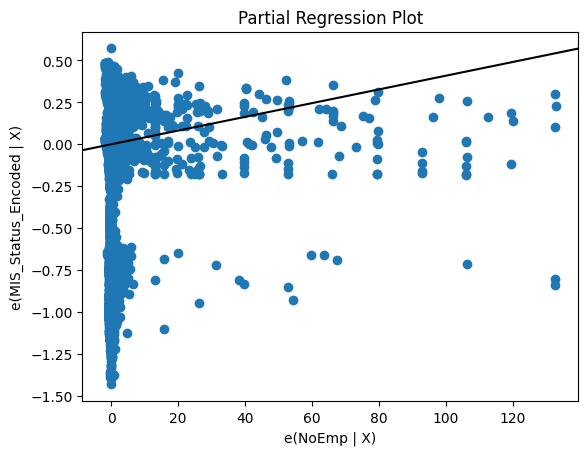

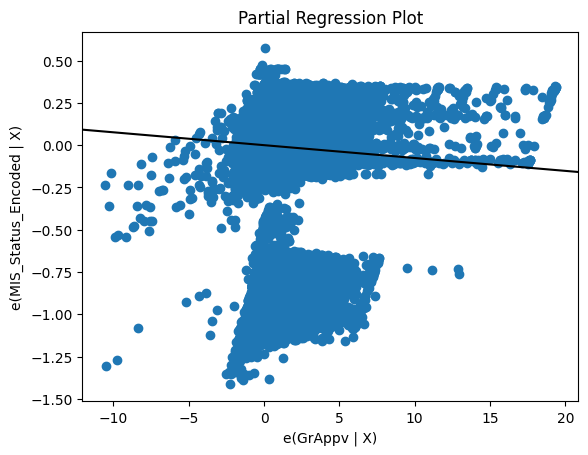

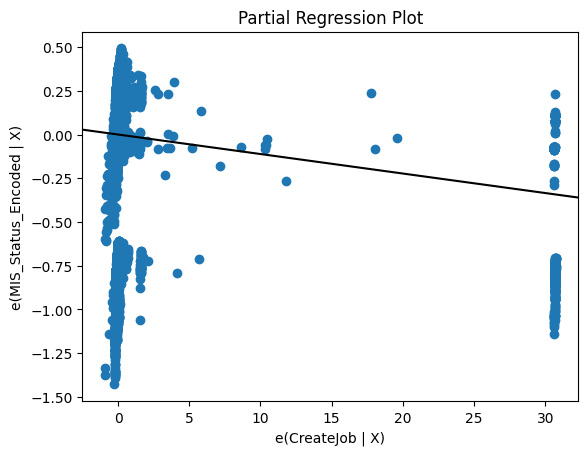

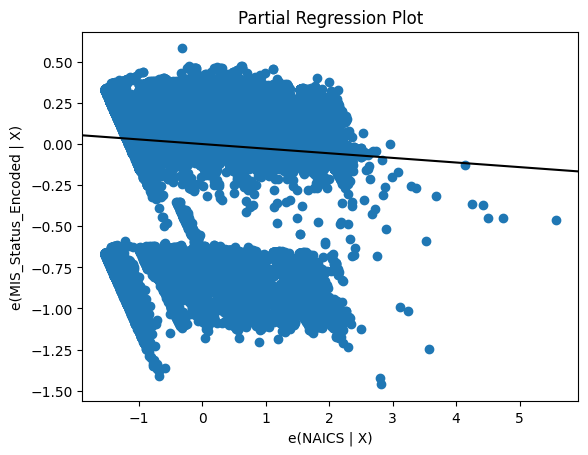

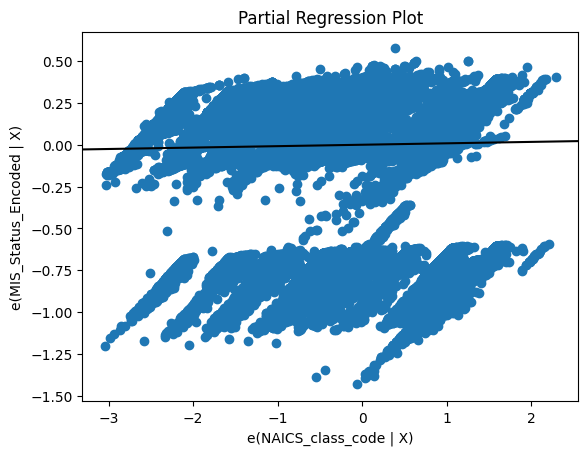

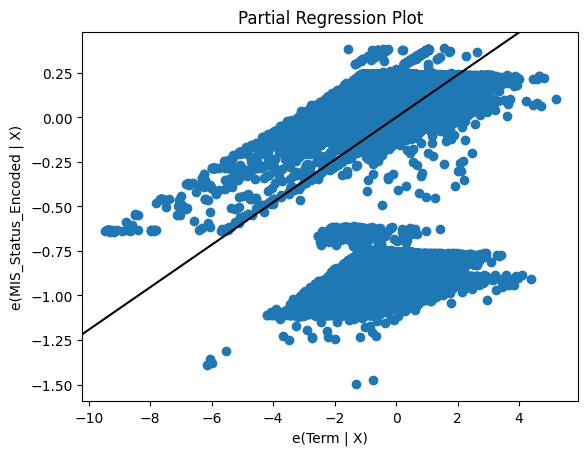

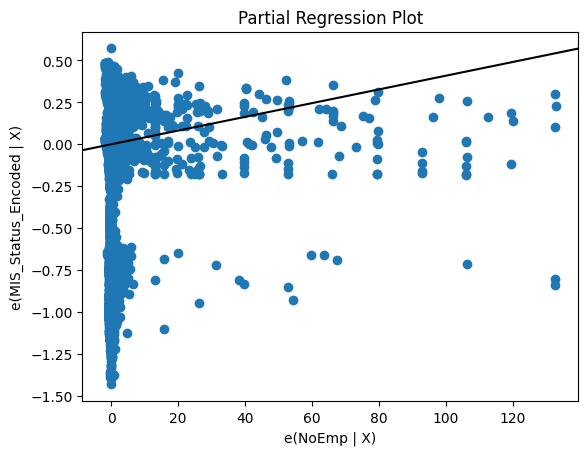

In [17]:
import statsmodels.api as sm
import statsmodels.graphics.api as smg
from sklearn.preprocessing import StandardScaler

# Create DataFrame
df_test = df_no_multicollinearity[['MIS_Status_Encoded', 'GrAppv', 'CreateJob', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp']]

# Select predictor features
continous_features = df_test[['GrAppv', 'CreateJob', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp']]

# Standardize the features
scaler = StandardScaler()
continous_features = scaler.fit_transform(continous_features)

# Convert the features to a DataFrame
continous_features = pd.DataFrame(continous_features, columns=['GrAppv', 'CreateJob', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp'])

# Target feature
target_feature = df_test['MIS_Status_Encoded']

# Concatenate the features and target
df_test_final = pd.concat([continous_features, target_feature], axis=1)

# Split the data into features and target
X = continous_features
y = df_test['MIS_Status_Encoded']

X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

# Partial regression plot for NAICS
smg.plot_partregress('MIS_Status_Encoded', 'GrAppv', exog_others=['CreateJob', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp'], data=df_test_final, obs_labels=False)

# Partial regression plot for NAICS
smg.plot_partregress('MIS_Status_Encoded', 'CreateJob', exog_others=['GrAppv', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp'], data=df_test_final, obs_labels=False)

# Partial regression plot for NAICS
smg.plot_partregress('MIS_Status_Encoded', 'NAICS', exog_others=['CreateJob', 'GrAppv', 'NAICS_class_code', 'Term', 'NoEmp'], data=df_test_final, obs_labels=False)

# Partial regression plot for NAICS_class_code
smg.plot_partregress('MIS_Status_Encoded', 'NAICS_class_code', exog_others=['CreateJob', 'NAICS', 'GrAppv', 'Term', 'NoEmp'], data=df_test_final, obs_labels=False)

# Partial regression plot for Term
smg.plot_partregress('MIS_Status_Encoded', 'Term', exog_others=['CreateJob', 'NAICS', 'GrAppv', 'NAICS_class_code', 'NoEmp'], data=df_test_final, obs_labels=False)

# Partial regression plot for NoEmp
smg.plot_partregress('MIS_Status_Encoded', 'NoEmp', exog_others=['CreateJob', 'NAICS', 'GrAppv', 'NAICS_class_code', 'Term'], data=df_test_final, obs_labels=False)


### Verify Relationship/Effect on Target

#### Point-Biseral Correlation (Continuous features and target)

#### Without Outliers

In [18]:
# Calculate Point Biserial Correlation
from scipy.stats import pointbiserialr

# Calculate the correlation between 'CreateJob' and 'MIS_Status_Encoded'
createjob_correlation, createjob_p_value = pointbiserialr(df_no_outliers['CreateJob'], df_no_outliers['MIS_Status_Encoded'])
noemp_correlation, noemp_p_value = pointbiserialr(df_no_outliers['NoEmp'], df_no_outliers['MIS_Status_Encoded'])
term_correlation, term_p_value = pointbiserialr(df_no_outliers['Term'], df_no_outliers['MIS_Status_Encoded'])
naics_correlation, naics_p_value = pointbiserialr(df_no_outliers['NAICS'], df_no_outliers['MIS_Status_Encoded'])
naicscode_correlation, naicscode_p_value = pointbiserialr(df_no_outliers['NAICS_class_code'], df_no_outliers['MIS_Status_Encoded']) 
grap_correlation, grap_p_value = pointbiserialr(df_no_outliers['GrAppv'], df_no_outliers['MIS_Status_Encoded'])   

# Print the correlation and p-value
print("CreateJob Correlation:", createjob_correlation , "Create Job P-value:", createjob_p_value)
print("NoEmp Correlation:", noemp_correlation , "NoEmp P-value:", noemp_p_value)
print("Term Correlation:", term_correlation , "Term P-value:", term_p_value)
print("NAICS Correlation:", naics_correlation , "NAICS P-value:", naics_p_value)
print("NAICS_class_code Correlation:", naicscode_correlation , "NAICS_class_code P-value:", naicscode_p_value)
print("GrAppv Correlation:", grap_correlation , "GrAppv P-value:", grap_p_value)

CreateJob Correlation: -0.13095909141127204 Create Job P-value: 0.0
NoEmp Correlation: 0.058802213005743675 NoEmp P-value: 7.005740615604794e-282
Term Correlation: 0.4095228133335639 Term P-value: 0.0
NAICS Correlation: -0.11992170622333632 NAICS P-value: 0.0
NAICS_class_code Correlation: 0.10106159668143583 NAICS_class_code P-value: 0.0
GrAppv Correlation: 0.11000698984841262 GrAppv P-value: 0.0


#### With Outliers

In [19]:
# Calculate Point Biserial Correlation
from scipy.stats import pointbiserialr

# Calculate the correlation between 'CreateJob' and 'MIS_Status_Encoded'
createjob_correlation, createjob_p_value = pointbiserialr(df_no_multicollinearity['CreateJob'], df_no_multicollinearity['MIS_Status_Encoded'])
noemp_correlation, noemp_p_value = pointbiserialr(df_no_multicollinearity['NoEmp'], df_no_multicollinearity['MIS_Status_Encoded'])
term_correlation, term_p_value = pointbiserialr(df_no_multicollinearity['Term'], df_no_multicollinearity['MIS_Status_Encoded'])
naics_correlation, naics_p_value = pointbiserialr(df_no_multicollinearity['NAICS'], df_no_multicollinearity['MIS_Status_Encoded'])
naicscode_correlation, naicscode_p_value = pointbiserialr(df_no_multicollinearity['NAICS_class_code'], df_no_multicollinearity['MIS_Status_Encoded']) 
grap_correlation, grap_p_value = pointbiserialr(df_no_multicollinearity['GrAppv'], df_no_multicollinearity['MIS_Status_Encoded'])   

# Print the correlation and p-value
print("CreateJob Correlation:", createjob_correlation , "Create Job P-value:", createjob_p_value)
print("NoEmp Correlation:", noemp_correlation , "NoEmp P-value:", noemp_p_value)
print("Term Correlation:", term_correlation , "Term P-value:", term_p_value)
print("NAICS Correlation:", naics_correlation , "NAICS P-value:", naics_p_value)
print("NAICS_class_code Correlation:", naicscode_correlation , "NAICS_class_code P-value:", naicscode_p_value)
print("GrAppv Correlation:", grap_correlation , "GrAppv P-value:", grap_p_value)

CreateJob Correlation: -0.013853150827191645 Create Job P-value: 1.9272609034916365e-27
NoEmp Correlation: 0.029890751151973285 NoEmp P-value: 2.566478672153594e-121
Term Correlation: 0.31804158356567513 Term P-value: 0.0
NAICS Correlation: -0.12775958976913127 NAICS P-value: 0.0
NAICS_class_code Correlation: 0.09761398044549453 NAICS_class_code P-value: 0.0
GrAppv Correlation: 0.1339701047092953 GrAppv P-value: 0.0


#### Chi-Square Test (Categorial features vs Target)

#### Without Outliers

In [20]:
df_no_outliers.head()

,MIS_Status_Encoded,NewExist_Encode,GrAppv,CreateJob,UrbanRural_Encoded,RevLineCr_Encoded,LowDoc_Encoded,NAICS,NAICS_class_code,FranchiseCode_Encoded,Term,NoEmp,RealEstate_Backed,Region_Eastern,Region_Northern,Region_Southern,Region_Western
0,1,0,60000,0,0,0,1,451120,45,0,84,4,0,1,0,0,0
1,1,0,40000,0,0,0,1,722410,72,0,60,2,0,1,0,0,0
3,1,1,35000,0,0,0,1,0,81,0,60,2,0,1,0,0,0
7,1,0,45000,0,0,0,1,811118,81,0,84,1,0,1,0,0,0
9,1,0,70000,0,0,0,1,0,81,0,84,3,0,0,1,0,0


In [21]:
df_no_multicollinearity.head()

,MIS_Status_Encoded,NewExist_Encode,GrAppv,CreateJob,UrbanRural_Encoded,RevLineCr_Encoded,LowDoc_Encoded,NAICS,NAICS_class_code,FranchiseCode_Encoded,Term,NoEmp,RealEstate_Backed,Region_Eastern,Region_Northern,Region_Southern,Region_Western
0,1,0,60000,0,0,0,1,451120,45,0,84,4,0,1,0,0,0
1,1,0,40000,0,0,0,1,722410,72,0,60,2,0,1,0,0,0
2,1,1,287000,0,0,0,0,621210,62,0,180,7,0,1,0,0,0
3,1,1,35000,0,0,0,1,0,81,0,60,2,0,1,0,0,0
4,1,1,229000,7,0,0,0,0,81,0,240,14,1,1,0,0,0


In [22]:
# Perform Chi-Square Test

from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table_NewExist_Encode_without_outliers = pd.crosstab(df_no_outliers['NewExist_Encode'], df_no_outliers['MIS_Status_Encoded'])
contingency_table_UrbanRural_Encode_without_outliers = pd.crosstab(df_no_outliers['UrbanRural_Encoded'], df_no_outliers['MIS_Status_Encoded'])
contingency_table_LowDoc_Encode_without_outliers = pd.crosstab(df_no_outliers['LowDoc_Encoded'], df_no_outliers['MIS_Status_Encoded'])     
contingency_table_RevLineCr_Encode_without_outliers = pd.crosstab(df_no_outliers['RevLineCr_Encoded'], df_no_outliers['MIS_Status_Encoded'])
contingency_table_FranchiseCode_Encode_without_outliers = pd.crosstab(df_no_outliers['FranchiseCode_Encoded'], df_no_outliers['MIS_Status_Encoded'])
contingency_table_RealEstate_Backed_without_outliers = pd.crosstab(df_no_outliers['RealEstate_Backed'], df_no_outliers['MIS_Status_Encoded']) 
contingency_table_Region_Eastern_witout_outliers = pd.crosstab(df_no_outliers['Region_Eastern'], df_no_outliers['MIS_Status_Encoded'])
contingency_table_Region_Northern_without_outliers = pd.crosstab(df_no_outliers['Region_Northern'], df_no_outliers['MIS_Status_Encoded'])
contingency_table_Region_Southern_without_outliers = pd.crosstab(df_no_outliers['Region_Southern'], df_no_outliers['MIS_Status_Encoded'])
contingency_table_Region_Western_without_outliers = pd.crosstab(df_no_outliers['Region_Western'], df_no_outliers['MIS_Status_Encoded'])


# Perform the Chi-Square Test
chi2_ne_no, p_ne_no, dof, expected = chi2_contingency(contingency_table_NewExist_Encode_without_outliers)
chi2_ur_no, p_ur_no, dof, expected = chi2_contingency(contingency_table_UrbanRural_Encode_without_outliers)
chi2_ld_no, p_ld_no, dof, expected = chi2_contingency(contingency_table_LowDoc_Encode_without_outliers)
chi2_rl_no, p_rl_no, dof, expected = chi2_contingency(contingency_table_RevLineCr_Encode_without_outliers)
chi2_fc_no, p_fc_no, dof, expected = chi2_contingency(contingency_table_FranchiseCode_Encode_without_outliers)
chi2_rb_no, p_rb_no, dof, expected = chi2_contingency(contingency_table_RealEstate_Backed_without_outliers)
chi2_re_no, p_re_no, dof, expected = chi2_contingency(contingency_table_Region_Eastern_witout_outliers)
chi2_rn_no, p_rn_no, dof, expected = chi2_contingency(contingency_table_Region_Northern_without_outliers)
chi2_rs_no, p_rs_no, dof, expected = chi2_contingency(contingency_table_Region_Southern_without_outliers)
chi2_rw_no, p_rw_no, dof, expected = chi2_contingency(contingency_table_Region_Western_without_outliers)

# Create Chi-Square DataFrame
chi_square_results_no_outliers = pd.DataFrame({
    'Feature': ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern', 'Region_Northern', 'Region_Southern', 'Region_Western'],
    'Chi-Square': [chi2_ne_no, chi2_ur_no, chi2_ld_no, chi2_rl_no, chi2_fc_no, chi2_rb_no, chi2_re_no, chi2_rn_no, chi2_rs_no, chi2_rw_no],
    'P-Value': [p_ne_no, p_ur_no, p_ld_no, p_rl_no, p_fc_no, p_rb_no, p_re_no, p_rn_no, p_rs_no, p_rw_no]
})

chi_square_results_no_outliers

,Feature,Chi-Square,P-Value
0,NewExist_Encode,753.162510,8.236826e-166
1,UrbanRural_Encoded,25436.672965,0.000000e+00
2,LowDoc_Encoded,10717.137797,0.000000e+00
3,RevLineCr_Encoded,2649.586059,0.000000e+00
4,FranchiseCode_Encoded,578.454632,8.132622e-128
5,RealEstate_Backed,0.000000,1.000000e+00
6,Region_Eastern,46.962672,7.235167e-12
7,Region_Northern,361.951840,1.058229e-80
8,Region_Southern,32.917198,9.616873e-09
9,Region_Western,895.941683,7.482595e-197


#### With outliers

In [23]:
# Perform Chi-Square Test

from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table_NewExist_Encode_with_outliers = pd.crosstab(df_no_multicollinearity['NewExist_Encode'], df_no_multicollinearity['MIS_Status_Encoded'])
contingency_table_UrbanRural_Encode_with_outliers = pd.crosstab(df_no_multicollinearity['UrbanRural_Encoded'], df_no_multicollinearity['MIS_Status_Encoded'])
contingency_table_LowDoc_Encode_with_outliers = pd.crosstab(df_no_multicollinearity['LowDoc_Encoded'], df_no_multicollinearity['MIS_Status_Encoded'])    
contingency_table_RevLineCr_Encode_with_outliers = pd.crosstab(df_no_multicollinearity['RevLineCr_Encoded'], df_no_multicollinearity['MIS_Status_Encoded']) 
contingency_table_FranchiseCode_Encode_with_outliers = pd.crosstab(df_no_multicollinearity['FranchiseCode_Encoded'], df_no_multicollinearity['MIS_Status_Encoded']) 
contingency_table_RealEstate_Backed_with_outliers = pd.crosstab(df_no_multicollinearity['RealEstate_Backed'], df_no_multicollinearity['MIS_Status_Encoded'])  
contingency_table_Region_Eastern_wit_outliers = pd.crosstab(df_no_multicollinearity['Region_Eastern'], df_no_multicollinearity['MIS_Status_Encoded'])
contingency_table_Region_Northern_with_outliers = pd.crosstab(df_no_multicollinearity['Region_Northern'], df_no_multicollinearity['MIS_Status_Encoded'])  
contingency_table_Region_Southern_with_outliers = pd.crosstab(df_no_multicollinearity['Region_Southern'], df_no_multicollinearity['MIS_Status_Encoded'])
contingency_table_Region_Western_with_outliers = pd.crosstab(df_no_multicollinearity['Region_Western'], df_no_multicollinearity['MIS_Status_Encoded'])

# Perform the Chi-Square Test
chi2_ne, p_ne, dof, expected = chi2_contingency(contingency_table_NewExist_Encode_with_outliers)
chi2_ur, p_ur, dof, expected = chi2_contingency(contingency_table_UrbanRural_Encode_with_outliers)
chi2_ld, p_ld, dof, expected = chi2_contingency(contingency_table_LowDoc_Encode_with_outliers)
chi2_rl, p_rl, dof, expected = chi2_contingency(contingency_table_RevLineCr_Encode_with_outliers)
chi2_fc, p_fc, dof, expected = chi2_contingency(contingency_table_FranchiseCode_Encode_with_outliers)
chi2_rb, p_rb, dof, expected = chi2_contingency(contingency_table_RealEstate_Backed_with_outliers)
chi2_re, p_re, dof, expected = chi2_contingency(contingency_table_Region_Eastern_wit_outliers)
chi2_rn, p_rn, dof, expected = chi2_contingency(contingency_table_Region_Northern_with_outliers)
chi2_rs, p_rs, dof, expected = chi2_contingency(contingency_table_Region_Southern_with_outliers)
chi2_rw, p_rw, dof, expected = chi2_contingency(contingency_table_Region_Western_with_outliers)

# Chi-Square Test DataFrame
chi_square_test = pd.DataFrame({
    'Feature': ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern', 'Region_Northern', 'Region_Southern', 'Region_Western'],
    'Chi-Square': [chi2_ne, chi2_ur, chi2_ld, chi2_rl, chi2_fc, chi2_rb, chi2_re, chi2_rn, chi2_rs, chi2_rw],
    'P-Value': [p_ne, p_ur, p_ld, p_rl, p_fc, p_rb, p_re, p_rn, p_rs, p_rw]
})

chi_square_test

,Feature,Chi-Square,P-Value
0,NewExist_Encode,10.465732,1.216093e-03
1,UrbanRural_Encoded,41924.398416,0.000000e+00
2,LowDoc_Encoded,7631.321937,0.000000e+00
3,RevLineCr_Encoded,10778.238617,0.000000e+00
4,FranchiseCode_Encoded,738.801121,1.092611e-162
5,RealEstate_Backed,20508.435351,0.000000e+00
6,Region_Eastern,13.834960,1.995879e-04
7,Region_Northern,106.687568,5.211858e-25
8,Region_Southern,0.639379,4.239359e-01
9,Region_Western,177.851011,1.427733e-40


In [24]:
chi_square_test

,Feature,Chi-Square,P-Value
0,NewExist_Encode,10.465732,1.216093e-03
1,UrbanRural_Encoded,41924.398416,0.000000e+00
2,LowDoc_Encoded,7631.321937,0.000000e+00
3,RevLineCr_Encoded,10778.238617,0.000000e+00
4,FranchiseCode_Encoded,738.801121,1.092611e-162
5,RealEstate_Backed,20508.435351,0.000000e+00
6,Region_Eastern,13.834960,1.995879e-04
7,Region_Northern,106.687568,5.211858e-25
8,Region_Southern,0.639379,4.239359e-01
9,Region_Western,177.851011,1.427733e-40


In [25]:
# df_no_multicollinearity['Stratify'] = df_no_multicollinearity.apply(
#     lambda row: f"{row['MIS_Status_Encoded']}_{row['FranchiseCode_Encoded']}", axis=1
# )

### Exploring Different Logistic Models

#### Logistic Regression

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression


# Split the data into features and target
X = df_no_multicollinearity.drop(columns=['MIS_Status_Encoded'])
y = df_no_multicollinearity['MIS_Status_Encoded']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['FranchiseCode_Encoded'])

# Define numerical and categorical features
numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'NAICS_class_code']
categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern', 'Region_Northern', 'Region_Southern', 'Region_Western']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ])

# Build Pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('logit', LogisticRegression()),
])

# Set RandomSearch parameters
params = {"logit__penalty" : ['l2'],
          "logit__solver" : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
}

# Set RandomSearchCV parameters
logit_random_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
logit_random_search.fit(X_train, y_train)

# Best parameterd and score
print("Best Params", logit_random_search.best_estimator_)
print("Best Score:", logit_random_search.best_score_)

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


Best Params Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['GrAppv', 'CreateJob',
                                                   'Term', 'NoEmp', 'NAICS',
                                                   'NAICS_class_code']),
                                                 ('cat', 'passthrough',
                                                  ['NewExist_Encode',
                                                   'UrbanRural_Encoded',
                                                   'LowDoc_Encoded',
                                                   'RevLineCr_Encoded',
                                                   'FranchiseCode_Encoded',
                                                   'RealEstate_Backed',
                                                   'Region_Eastern',
                                                   'Region_Northern',
             

In [ ]:
# Import the accuracy metric
from sklearn.metrics import accuracy_score, auc, roc_curve, f1_score

# Load model
logistic_model = logit_random_search.best_estimator_

# Make predictions
y_pred = logistic_model.predict(X_test)

# Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# auc_score = auc(y_test, y_pred)
# roc_curve_view = roc_curve(y_test, y_pred)
# f1_score_score = f1_score(y_test, y_pred, average= 'binary')

In [27]:
# from sklearn.model_selection import cross_val_score

# # Evaluate model using cross-validation
# logit_scores = cross_val_score(logit_random_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
# print(f'ROC-AUC: {logit_scores.mean()}')

#### Random Forest Classifier

In [28]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # Split the data into features and target
# X = df_no_multicollinearity.drop(columns=['MIS_Status_Encoded'])
# y = df_no_multicollinearity['MIS_Status_Encoded']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['FranchiseCode_Encoded'])

# # Define numerical and categorical features
# numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'NAICS_class_code']
# categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern', 'Region_Northern', 'Region_Southern', 'Region_Western']

# # Define the preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', 'passthrough', categorical_features)
#     ])

# # Build Pipeline
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
#     ('random', RandomForestClassifier()),
# ])

# # Set RandomSearch parameters
# params = {"random__random_state": [None],
# }

# # Set RandomSearchCV parameters
# rf_random_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
# rf_random_search.fit(X_train, y_train)

# # Best parameterd and score
# print("Best Params", rf_random_search.best_estimator_)
# print("Best Score:", rf_random_search.best_score_)

# # Make predictions
# # y_pred = logistic_model.predict(X_test)

# # Import the accuracy metric
# # from sklearn.metrics import accuracy_score, auc, roc_curve, f1_score

# # # Calculate the accuracy
# # accuracy = accuracy_score(y_test, y_pred)
# # auc_score = auc(y_test, y_pred)
# # roc_curve_view = roc_curve(y_test, y_pred)
# # f1_score_score = f1_score(y_test, y_pred)

In [29]:
# rf_scores = cross_val_score(rf_random_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
# print(f'ROC-AUC: {rf_scores.mean()}')

#### XGBoost

In [ ]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# import xgboost as xgb

# # Split the data into features and target
# X = df_no_multicollinearity.drop(columns=['MIS_Status_Encoded'])
# y = df_no_multicollinearity['MIS_Status_Encoded']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['FranchiseCode_Encoded'])

# # Define numerical and categorical features
# numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'NAICS_class_code']
# categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern', 'Region_Northern', 'Region_Southern', 'Region_Western']

# # Define the preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', 'passthrough', categorical_features)
#     ])

# # Build Pipeline
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
#     ('xgb', xgb.XGBRFClassifier()),
# ])

# # Set RandomSearch parameters
# params = {"xgb__booster" : ['gbtree']}

# # Set RandomSearchCV parameters
# xgb_random_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
# xgb_random_search.fit(X_train, y_train)

# # Best parameterd and score
# print("Best Params", xgb_random_search.best_estimator_)
# print("Best Score:", xgb_random_search.best_score_)

In [31]:
# xgb_scores = cross_val_score(xgb_random_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
# print(f'ROC-AUC: {xgb_scores.mean()}')